In [1]:
import os

# Désactiver le GPU en définissant CUDA_VISIBLE_DEVICES à un vide#
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [78]:
import importlib

import RktnChallenge.RktnModel
importlib.reload(RktnChallenge.RktnModel)
from RktnChallenge.RktnModel import ModelTrainer


from RktnChallenge.preprocessing.tokenizeString import tokenizeString
from RktnChallenge.preprocessing.filterStopWords import filterStopWords
from RktnChallenge.preprocessing.mergeFeatures import mergeFeatures
from RktnChallenge.preprocessing.mostOccur import mostOccur
from RktnChallenge.preprocessing.Dropper import Dropper
from RktnChallenge.preprocessing.TokenListToString import TokenListToString
from RktnChallenge.preprocessing.filterChar import filterChar

import RktnChallenge.preprocessing.lemmatize
importlib.reload(RktnChallenge.preprocessing.lemmatize)
from RktnChallenge.preprocessing.lemmatize import lemmatize

import RktnChallenge.preprocessing.regularExprSub
importlib.reload(RktnChallenge.preprocessing.regularExprSub)
from RktnChallenge.preprocessing.regularExprSub import regularExprSub

In [79]:
RktnModel = ModelTrainer("data_tr.csv")
RktnModel.data=RktnModel.data[RktnModel.data.description.notna() ]

Removing StopWords

In [ ]:
On crop puis on merge

In [77]:
addendum = ['a','à','<p>','<b>','<div>','<em>','<br>']

#on tokenise et retire les stopwords designation

desi_tokenize= tokenizeString("designation_tkn","designation")
desi_stopwords = filterStopWords("designation_tkn", "designation_tkn"
                                 ,lang=["english","french"],addendum=addendum)


#on tokenise et retire les stopwords description
desc_tokenize= tokenizeString("description_tkn","description")
desc_stopwords = filterStopWords("description_tkn", "description_tkn"
                                 ,lang=["english","french"],addendum=addendum)


desc_mostOccur= mostOccur("desc_reduce","description_tkn",250,250)

merge_desi_desc = mergeFeatures("merged_desi_desc","designation_tkn","desc_reduce")

toString = TokenListToString("merged_desi_desc","merged_desi_desc")
toDrop = ["designation_tkn","description_tkn","desc_reduce"]
cleanDropper = Dropper(column_to_drop = toDrop)

RktnModel.initPreprocess()
RktnModel.addPreprocessStep("tokenize designation",desi_tokenize) # transformation en token
RktnModel.addPreprocessStep("filter designation",desi_stopwords)  # filtrage des stopwords
RktnModel.addPreprocessStep("tokenize description",desc_tokenize) # transformation en token
RktnModel.addPreprocessStep("filter description",desc_stopwords)  # filtrage des stopwords
RktnModel.addPreprocessStep("desc reduce",desc_mostOccur)         # reduction taille desc
RktnModel.addPreprocessStep("merge designation and desc",merge_desi_desc) # merge desi&desc
RktnModel.addPreprocessStep("to string",toString) # merge desi&desc

#RktnModel.addPreprocessStep("cleaning",cleanDropper) # on clean les colonnes crées
RktnModel.preprocess()



[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


KeyboardInterrupt: 

83.52%

On merge et on crop ensuite

In [80]:
addendum = ['a','à','<p>','<b>','<div>','<em>','<br>']

#on tokenise et retire les stopwords designation

desi_tokenize= tokenizeString("designation_tkn","designation")
desi_stopwords = filterStopWords("designation_tkn", "designation_tkn"
                                 ,lang=["english","french"],addendum=addendum)


#on tokenise et retire les stopwords description
desc_tokenize= tokenizeString("description_tkn","description")
desc_stopwords = filterStopWords("description_tkn", "description_tkn"
                                 ,lang=["english","french"],addendum=addendum)



merge_desi_desc = mergeFeatures("merged","designation_tkn","description_tkn")
desc_mostOccur= mostOccur("merged_desi_desc","merged",1000,1000)



toDrop = ["designation_tkn","description_tkn","merged"]
cleanDropper = Dropper(column_to_drop = toDrop)
toString = TokenListToString("merged_desi_desc","merged_desi_desc")

RktnModel.initPreprocess()
RktnModel.addPreprocessStep("tokenize designation",desi_tokenize) # transformation en token
RktnModel.addPreprocessStep("filter designation",desi_stopwords)  # filtrage des stopwords
RktnModel.addPreprocessStep("tokenize description",desc_tokenize) # transformation en token
RktnModel.addPreprocessStep("filter description",desc_stopwords)  # filtrage des stopwords
RktnModel.addPreprocessStep("merge designation and desc",merge_desi_desc) # merge desi&desc
RktnModel.addPreprocessStep("desc reduce",desc_mostOccur)         # reduction taille desc
RktnModel.addPreprocessStep("tostring",toString) # merge desi&desc

#RktnModel.addPreprocessStep("cleaning",cleanDropper) # on clean les colonnes crées
RktnModel.preprocess()



[nltk_data] Downloading package stopwords to /home/pec/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/pec/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


83.77

In [3]:
addendum = ['a','à','<p>','<b>','<div>','<em>','<br>']

#on tokenise et retire les stopwords designation

desi_tokenize= tokenizeString("designation_tkn","designation")
desi_stopwords = filterStopWords("merged_desi_desc", "designation_tkn"
                                 ,lang=["english","french"],addendum=addendum)



RktnModel.initPreprocess()
RktnModel.addPreprocessStep("tokenize designation",desi_tokenize) # transformation en token
RktnModel.addPreprocessStep("filter designation",desi_stopwords)  # filtrage des stopwords



#RktnModel.addPreprocessStep("cleaning",cleanDropper) # on clean les colonnes crées
RktnModel.data = RktnModel.preprocess()


[nltk_data] Downloading package stopwords to /home/pec/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


81.72

Vectorization des données

In [81]:
_X = RktnModel.data["merged_desi_desc"]

RktnModel.create_vectorizer(name="tokenizer", X = _X, ngram_range=(1,3))

X_data = RktnModel.vectorizer_transform(_X)     


y = RktnModel.encodeLabel("prdtypecode")
label_size = RktnModel.getLabelSize()

In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size = 0.20, random_state = 42)


Definition d'un modele

In [83]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRUCell,RNN,GRU, Dense,Dropout,GlobalAveragePooling2D, LSTM, Flatten, Input
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.models import Model

_latent_dim = 100

vocab_size = RktnModel.vocab_size
max_seq_length = RktnModel.max_seq_length
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=_latent_dim, input_length=max_seq_length, mask_zero=True),     
    Flatten(),   
    #Dense(units=nb_units, activation="relu"),
    Dense(units=label_size, activation="softmax")
])


 
optimizer = AdamW(weight_decay=0.01, learning_rate=0.001) 
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 992, 100)          17050300  
                                                                 
 flatten_3 (Flatten)         (None, 99200)             0         
                                                                 
 dense_3 (Dense)             (None, 27)                2678427   
                                                                 


Total params: 19728727 (75.26 MB)
Trainable params: 19728727 (75.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [87]:
history = model.fit(X_train, y_train, epochs=1, batch_size=100, validation_split=0.2)

353/353 [==============================] - 16s 46ms/step - loss: 0.0511 - accuracy: 0.9919 - val_loss: 0.4505 - val_accuracy: 0.8718


In [51]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, GRU, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW



embedding_dim = 150  # Dimension de l'incorporation des mots


# Entrée du modèle
input_layer = Input(shape=(RktnModel.max_seq_length,))
embedding_layer = Embedding(input_dim=RktnModel.vocab_size, output_dim=embedding_dim)(input_layer)

# Couche GRU
gru_layer = GRU(units=64, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)


# Couches denses
dense_layer = Dense(units=128, activation='relu')(gru_layer)
dropout_layer = Dropout(0.2)(dense_layer)
output_layer = Dense(units=label_size, activation='softmax')(dropout_layer)

# Création du modèle
model = Model(inputs=input_layer, outputs=output_layer)
 
optimizer = AdamW(weight_decay=0.01, learning_rate=0.001) 
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 992)]             0         
                                                                 
 embedding_9 (Embedding)     (None, 992, 400)          68201200  
                                                                 
 gru_1 (GRU)                 (None, 64)                89472     
                                                                 
 dense_12 (Dense)            (None, 128)               8320      
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 27)                3483      
                                                                 
Total params: 68302475 (260.55 MB)
Trainable params: 683024

344/344 [==============================] - 0s 1ms/step
weighted F1 score: 0.8688494515848769


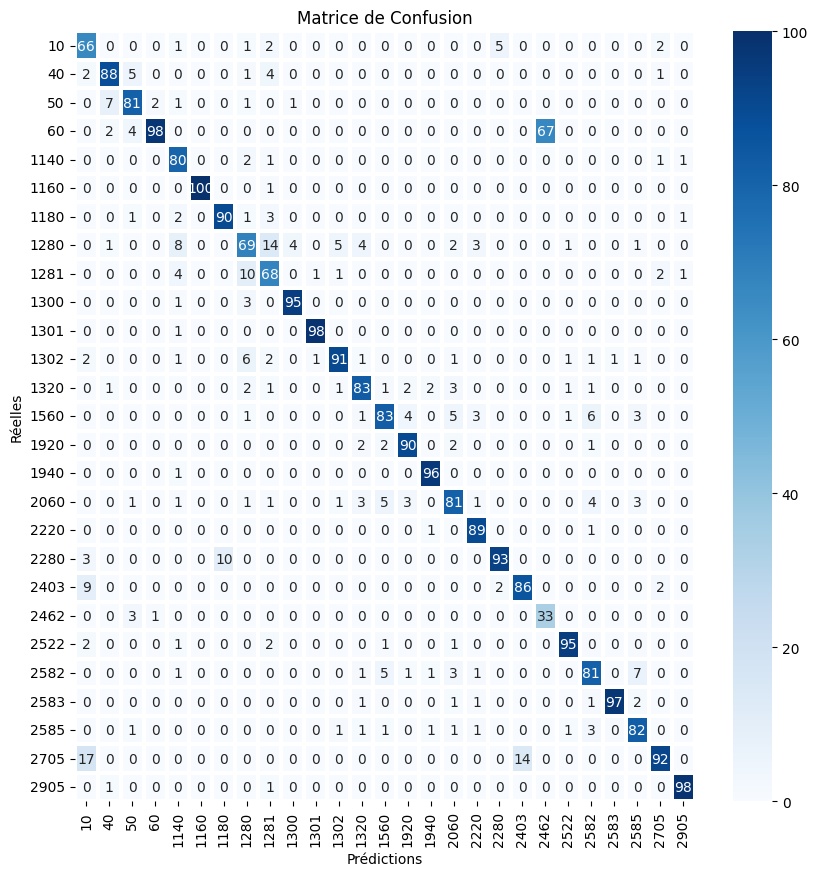

/home/pec/miniconda3/envs/tfGPU/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [89]:


y_pred_test = model.predict(X_test)
y_pred_id = y_pred_test.argmax(axis=-1)

RktnModel.evaluateTestResults(y_test,y_pred_id)


model.save("model_description.h5")